<a href="https://colab.research.google.com/github/nandorrefi/BreakoutAI/blob/main/BreakoutAI_Acme.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installs

In [ ]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1

Requirement already up-to-date: setuptools in /usr/local/lib/python3.6/dist-packages (53.0.0)


In [ ]:
!pip install dm-env
!pip install dm-acme
!pip install dm-acme[reverb]
!pip install dm-acme[tf]
!pip install tensorflow-gpu tensorflow-probability
!pip install dm-sonnet

     |████████████████████████████████| 163kB 6.4MB/s 
  Created wheel for dm-acme: filename=dm_acme-0.2.0-cp36-none-any.whl size=301691 sha256=9717c8d7db473c5fd4ac2b977374782c882791100cf4b1d7d052d0aefffdcd7e
  Stored in directory: /root/.cache/pip/wheels/c6/a6/ce/4e74a16a8104a938ded5c7b26800de89db1b415c9d3465459a
Successfully built dm-acme
     |████████████████████████████████| 6.3MB 4.5MB/s 
     |████████████████████████████████| 102kB 4.1MB/s 
     |████████████████████████████████| 256kB 14.8MB/s 
     |████████████████████████████████| 394.3MB 28kB/s 


In [ ]:
import os
os.kill(os.getpid(), 9)

# Init

In [ ]:
import dm_env
from dm_env import specs

from acme.wrappers import GymAtariAdapter
from acme.wrappers import GymWrapper

import sonnet as snt
import tensorflow as tf

from acme.agents.tf.dqn import DQN
from acme import make_environment_spec

from gym.spaces import Box
from gym.spaces import Discrete

In [ ]:
import gym
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import cv2
from IPython import display
from collections import deque

In [ ]:
def draw_state(state):
    plt.figure(figsize=(18,8))
    plt.imshow(np.array(state))
    plt.show()

In [ ]:
def preprocess(state):
    state = cv2.resize(state, (84, 110), cv2.COLOR_BGR2GRAY)
    state = state[17:109,4:80]
    _,state = cv2.threshold(state, 1, 255, cv2.THRESH_BINARY)
    state = np.mean(state, axis=2)
    state = state/np.max(state)
    return np.array(state, dtype=np.float32)[..., np.newaxis]

In [ ]:
class DiscreteWrapper(Discrete):
    def __init__(self, discrete: Discrete):
        n = discrete.n
        assert n >= 0
        self.n = n
        super(Discrete, self).__init__((), np.int32)

In [ ]:
class DataLogger():
    def __init__(self):
        self._total_rewards = []
        self._episode_length = []
        self._avg_total_rewards = []
        self._avg_freq = 10
    
    def log(self, total_reward, length):
        self._total_rewards.append(total_reward)
        self._episode_length.append(length)

        freq = self._avg_freq
        if(len(self._total_rewards) >= freq):
            self._avg_total_rewards.append(np.mean(self._total_rewards[-freq:]))

    def get_data(self):
        return (self._total_rewards, self._avg_total_rewards, self._episode_length)

In [ ]:
class DataPlotter():
    def __init__(self, data, titles, xlabels, ylabels):
        self.data = data
        self.titles = titles
        self.xlabels = xlabels
        self.ylabels = ylabels

    def plot(self):
        display.clear_output(wait=True)
        display.display(plt.clf())

        for i, values in enumerate(self.data):
            title = self.titles[i]
            xlabel = self.xlabels[i]
            ylabel = self.ylabels[i] 

            plt.plot(values)
            plt.title(title)
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)
            plt.show()

In [ ]:
class EnvWrapper(gym.Env):
    def __init__(self, preprocessor, logger: DataLogger):
        self._preprocessor = preprocessor
        self._data_logger = logger
        self._episode_total_reward = 0
        self._episode_length = 0

        data = self._data_logger.get_data()
        titles = ['Episode reward over time', 'Average reward', 'Episode length over time']
        xlabels = ['Episode', 'Last 10 episode', 'Episode']
        ylabels = ['Total reward', 'Average reward', 'Length']

        self._plotter = DataPlotter(data, titles, xlabels, ylabels)

        self.env = gym.make('BreakoutDeterministic-v4')

        obs = preprocessor(self.env.reset())
        self.observation_space = Box(np.min(obs), np.max(obs), obs.shape, obs.dtype)
        self.action_space = DiscreteWrapper(self.env.action_space)
        self.ale = self.env.ale
        self.current_lives = self.ale.lives()

    def step(self, action):
        observation, reward, done, info = self.env.step(action)
        observation = self._preprocessor(observation)

        if(self.ale.lives() < self.current_lives):
            reward = -1.0
            self.current_lives = self.ale.lives()

        self._episode_total_reward += reward
        self._episode_length += 1

        return (observation, reward, done, info)

    def reset(self):
        self._log_episode()
        self._plotter.plot()
        state = self._preprocessor(self.env.reset())
        self.current_lives = self.ale.lives()

        return state

    def _log_episode(self):
        self._data_logger.log(self._episode_total_reward, self._episode_length)
        self._episode_total_reward = 0
        self._episode_length = 0

    def render(self, mode='human'):
        return self.env.render(mode)

    def close(self):
        self.env.close()

    def seed(self, seed=None):
        return self.env.seed(seed)


In [ ]:
data_logger = DataLogger()

In [ ]:
env = EnvWrapper(preprocess, data_logger)
acme_env = GymWrapper(env)
env_specs = make_environment_spec(acme_env)

In [ ]:
network = snt.Sequential([
    # input shape: (?, 92, 76, 1)
    snt.Conv2D(2, 4, 2),
    tf.nn.relu,
    snt.Conv2D(4, 3, 2),
    tf.nn.relu,
    snt.Conv2D(8, 4, 2),
    tf.nn.relu,
    snt.Flatten(),
    snt.Linear(128),
    tf.nn.relu,
    snt.Linear(4),
    tf.nn.softmax
])

In [ ]:
from acme import EnvironmentLoop
from acme.utils import loggers

In [ ]:
agent = DQN(env_specs, network, max_replay_size=20000, logger=loggers.NoOpLogger(), checkpoint=False)

None

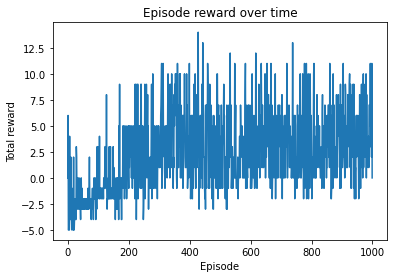

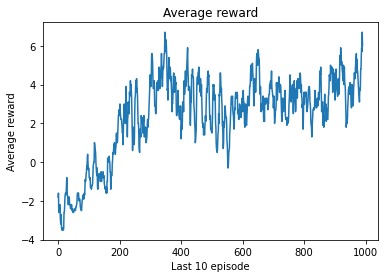

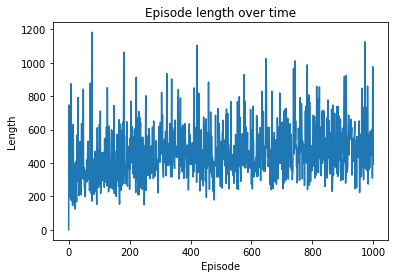

In [ ]:
loop = EnvironmentLoop(acme_env, agent, logger=loggers.NoOpLogger())
loop.run(num_episodes=1000)